### Import Statements

In [2]:
import numpy as np
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import matplotlib.pyplot as plt
import csv
import pandas as pd

## Classes

In [3]:
class randomForest(object):
    def __init__(self, n_estimators, max_depth, max_features, random_seed=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_seed = random_seed
        self.row_indices = []
        self.feature_indices = []
        self.out_of_bag = []
        self.decision_trees = [sklearn.tree.DecisionTreeClassifier(max_depth=None, criterion='entropy') for i in range(n_estimators)]

    def bootstrap(self, num_training, num_features, random_seed = None):
        np.random.seed(seed = self.random_seed)
        for i in range(self.n_estimators):
            total = set(list(range(num_training)))
            row_indices, col_indices = np.random.choice(num_training, num_training), np.random.choice(num_features, int(num_features * self.max_features), replace=False)
            total = total - set(row_indices)
            self.row_indices.append(row_indices)
            self.feature_indices.append(col_indices)
            self.out_of_bag.append(total)
    
    def fit_rforest(self, x, y):
        self.bootstrap(np.shape(x)[0], np.shape(x)[1])
        for i in range(self.n_estimators):
            bsX = x[self.row_indices[i]][:,self.feature_indices[i]]
            bsY = y[self.row_indices[i]]
            self.decision_trees[i].fit(bsX, bsY)

    def accuracy(self, X, y):
        accuracy = []
        for i in range(len(X)):
            predictions = []
            for j in range(self.n_estimators):
                if i in self.out_of_bag[j]:
                    predictions.append(self.decision_trees[j].predict(np.reshape(X[i][self.feature_indices[j]], (1,-1)))[0])
            if len(predictions) > 0:
                accuracy.append(np.sum(predictions == y[i]) / float(len(predictions)))
        return np.mean(accuracy)


In [4]:
class Cleaning(object):
    #class to handle cleaning data (standardizing features, dimensionality reduction, etc.)
    
    #PCA for dimensionality reduction of the dataset
    def pca(self, X, var = False, k=2):
        """
        ARGS:
            X: (N X D) data set as a numpy array, uncentered
            var: whether to use retained variance or number of features as the basis of reduction
            k: if var=FALSE, k is the number of features to be kept. if var=TRUE, k is the retained variance as a decimal

        RETURNS:
            new_data: dataset (as a numpy array) obtained by applying PCA on the original dataset
        """

        #center the data set
        centeredData = X - np.mean(X, axis=0)
        __, S, V = np.linalg.svd(centeredData, full_matrices = False)

        #if var== False, do PCA based on the specified number of features
        if (var == False):
            #if k not entered correctly (less than one feature entered), assume default number of features
            if (k < 1):
                k = 2
            V = V[0:k,:]
            new_data = np.matmul(centeredData, V.T)
        
        #if var==True, do PCA based on the specified number of features
        else:
            #if k not entered correctly (greater than 100%), assume default variance
            if (k >= 1):
                k = .99
            new_data = np.matmul(centeredData, V.T)
            ssquared = np.square(S)
            origVar = np.sum(ssquared)
            for i in range(np.shape(centeredData)[1]):
                var = np.sum(ssquared[0:i])/origVar
                if (var >= k):
                    V_temp = V[0:i,:]
                    new_data= np.matmul(centeredData, V_temp.T)
                    break
        return new_data





## Training and Testing the Model

In [5]:
csv_file = open('KickStarterData_nb.csv', encoding="utf-8")
csv_reader = csv.reader(csv_file, delimiter=',')

csv_list = list(csv_reader)
#remove one for the feature titles
totalN = len(csv_list) - 1
#remove 2 for the id and the y column
D = len(csv_list[1]) - 2

#remove the feature titles
csv_list.pop(0)
#split into x and y, remove id
nparray = np.array(csv_list)

#shape of X: (331675, 6)
X = nparray[0:totalN,1:]
#shape of y: (331675,)
y = nparray[:, D+1]


#split into training and testing data
train = int(totalN*0.1)
Xtrain = X[:train]
ytrain = y[:train]

Xtest = X[train+1:]
ytest = y[train+1:]


random_forest = sklearn.ensemble.RandomForestClassifier(bootstrap=True)
random_forest.fit(Xtrain, ytrain)
ypredicted = random_forest.predict(Xtest)

accuracy = sklearn.metrics.accuracy_score(ytest,ypredicted)
print(accuracy)

totalCorrect = 0
for i in range(np.shape(ytest)[0]):
    if ytest[i] == ypredicted[i]:
        totalCorrect += 1

print(totalCorrect/np.shape(ytest)[0])

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
sklearn.tree.plot_tree(random_forest.estimators_[0],
               feature_names = random_forest.feature_importances_, 
               class_names=random_forest.classes_,
               filled = True);
fig.savefig('rf_individualtree.png')


KeyboardInterrupt: 

The model had an accuracy of 0.9028.
The model had a precision of 0.8529.
The model had a recall of 0.9162.
The model had an f1 score of 0.8834.


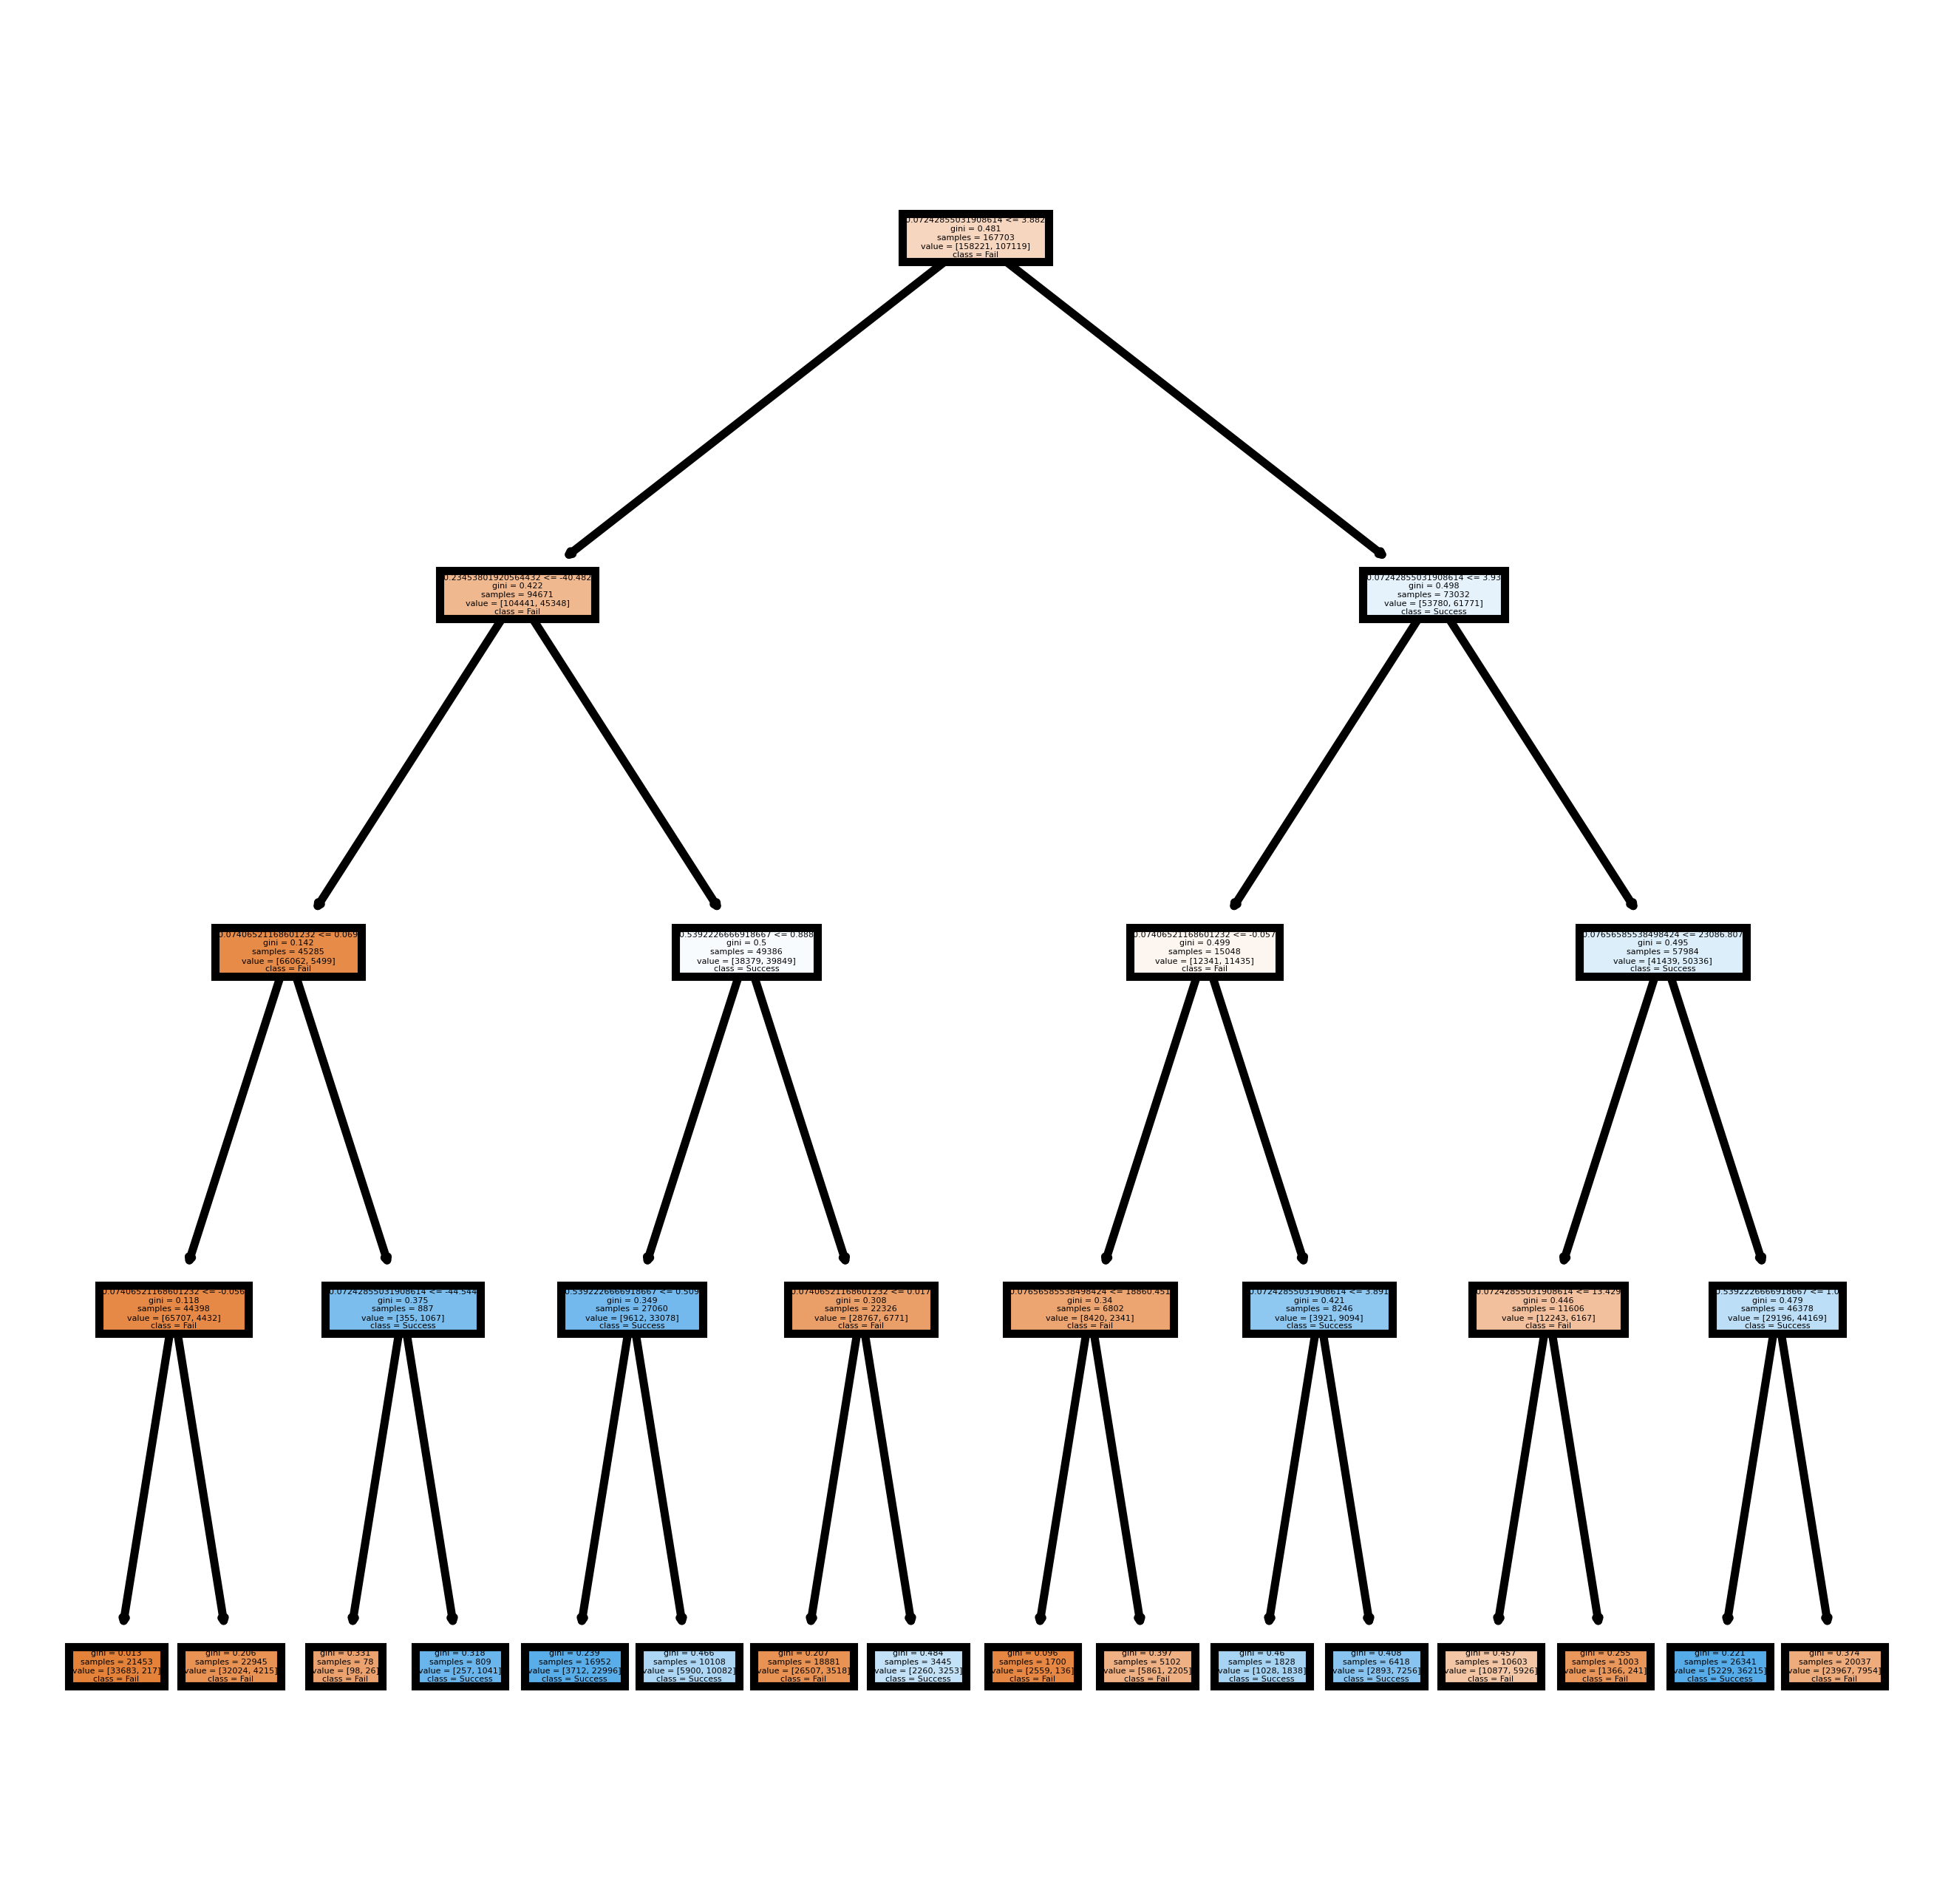

In [7]:
# Dataset constants ==============================
N = 331675   # Number of points
D = 7   # Number of (useful) features
C = 172    # Number of unique categories
mC = 1508    # Largest label coding (plus one for array creation purposes)
M = 12    # Number of unique months

# Load test file
csv_file = open('KickStarterData_nb.csv', encoding="utf-8")
csv_reader = csv.reader(csv_file, delimiter=',')
        
data_arr = np.empty((N, D + 1))    # D + 1 since need to account for the labels
counter = -2    # For skipping the row of feature names 
for row in csv_reader:
    counter += 1
    if (counter == -1):
        continue
                            
    temp_arr = np.array(row)
    data_arr[counter] = temp_arr[1:]    # Ignores the ID vaules

# Splits the data between data points and labels
X = data_arr[:, 0:D]
y = data_arr[:, D]

# Cleans the data
ord_columns = X[:, 0:2]    # Isolate the odrinal data
clean = Cleaning()
cleaned_x = clean.pca(X[:, 2:], k=5)    # Don't run ordinal data through PCA
cleaned_x = np.hstack((ord_columns, cleaned_x))


# Test on 20% of the dataset
test_amount = N // 5
Xtest = cleaned_x[0:test_amount, :]
ytest = y[0:test_amount]
Xtrain = cleaned_x[test_amount:, :]
ytrain = y[test_amount:]


random_forest = RandomForestClassifier(max_depth=4)
random_forest.fit(Xtrain, ytrain)
ypredicted = random_forest.predict(Xtest)

accuracy = sklearn.metrics.accuracy_score(ytest,ypredicted)
precision = sklearn.metrics.precision_score(ytest, ypredicted)
recall = sklearn.metrics.recall_score(ytest, ypredicted)
f1 = sklearn.metrics.f1_score(ytest, ypredicted)
print("The model had an accuracy of %.4f." % accuracy)
print("The model had a precision of %.4f." % precision)
print("The model had a recall of %.4f." % recall)
print("The model had an f1 score of %.4f." % f1)

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
sklearn.tree.plot_tree(random_forest.estimators_[0],
               feature_names = random_forest.feature_importances_, 
               class_names=["Fail", "Success"],
               filled = True);
plt.show()
fig.savefig('rf_individualtree.png')


## Visualization

In [ ]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
importances = random_forest.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()